## Analysis of cluster data produced by mPIXdaq
                                                    Günter Quast, Aug. 2025

This code analyzes the properties of pixel clusters derived from miniPIX frames 
uning the class `frameAnalyzer` of the Python package *mpixdaq*. The class 
is shown here:

``` 
Class frameAnalyzer: 
    Analyze frame data  

    - find clusters  
    - compute cluster energies  
    - compute position and covariance matrix of x- and y-coordinates  
    - analyze cluster shape (using eigenvalues of covariance matrix)  
    - construct a tuple with cluster properties  

    Note: this algorithm only works if clusters do not overlap!

    Args: a 2d-frame from the miniPIX

    Returns:

    - n_pixels: number of pixels with energy > 0
    - n_clusters: number of clusters
    - n_cpixels: number of pixels per cluster
    - circularity: circularity per cluster (0. for linear, 1. for circular)
    - cluster_energies: energy per cluster

    - self.clusters is a tuple with properties per cluster with mean of x and y coordinates,
       number of pixels, energy, eigenvalues of covariance matrix and orientation of the eigenvector
       corresponing to the largest eigenvalue in the range [-pi/2, pi/2].   
         format of hte tuple:
              ( (x,y), n_pix, energy, (var_mx, var_mn), angle )

```
These proberties per cluster or single, isolated pixel are exported to a *.csv* file with header   
   **x_mean** 	**y_mean** 	**n_pix** 	**energy** 	**var_mx** 	**var_mn** 	**angle**   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.colors import LogNorm

#### Import data and add derived quantities

In [2]:
# import data in a pandas data frame
#df = pd.read_csv("data/BlackForestStone_clusters.csv.gz")
df = pd.read_csv("test.csv")

# add derived quantities
#  - circularity defined as the ratio of the smaller and the larger eigenvalue 
#    of the covariance matrix of the pixels in a cluster
df['circularity'] = df['var_mn']/df['var_mx']

# show data
display(df)

,x_mean,y_mean,n_pix,energy,var_mx,var_mn,angle,circularity
0,4.46,72.67,14,487.0,3.31,1.11,-0.89,0.335347
1,14.00,168.50,2,10.0,0.25,0.00,0.00,0.000000
2,27.19,235.93,7,337.0,0.75,0.12,-1.01,0.160000
3,62.58,165.03,9,197.0,5.26,0.11,-0.83,0.020913
4,94.58,128.40,15,2752.0,0.31,0.29,-0.88,0.935484
...,...,...,...,...,...,...,...,...
19634,54.17,4.82,5,160.0,0.33,0.13,-1.27,0.393939
19635,148.85,186.51,4,65.0,0.25,0.13,-0.01,0.520000
19636,193.66,191.15,11,374.0,2.48,0.27,0.19,0.108871
19637,233.60,208.84,4,116.0,0.24,0.13,1.37,0.541667


#### Produce an overview of the distributions of the input variables

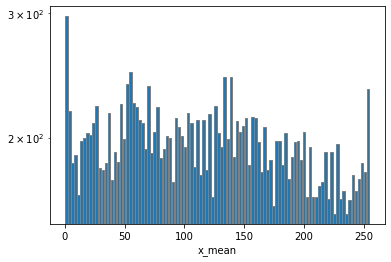

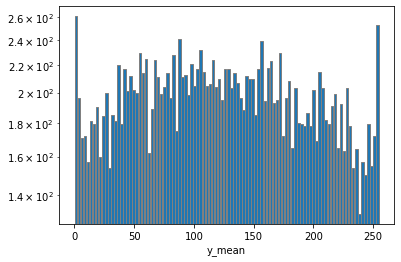

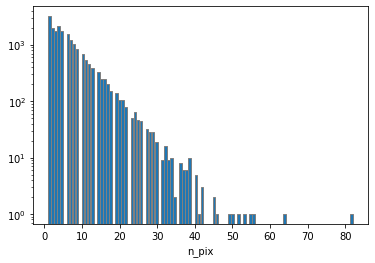

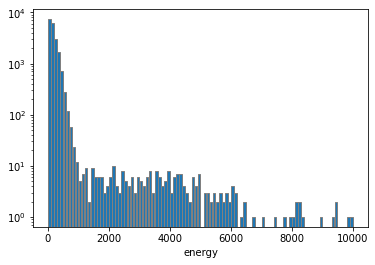

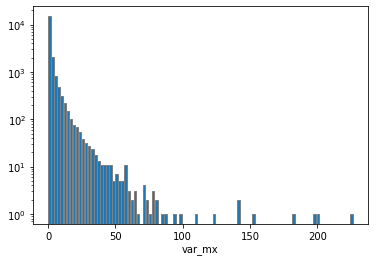

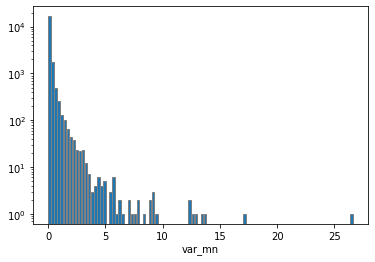

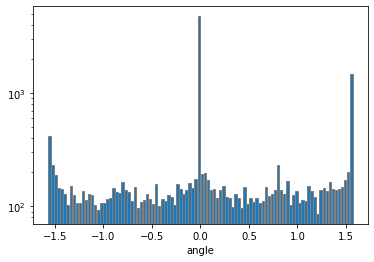

/usr/lib64/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib64/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


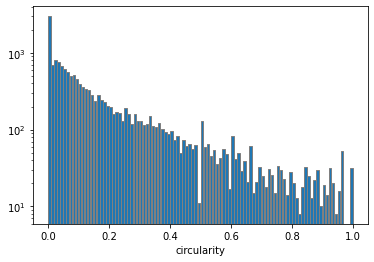

In [3]:
def plt_keys(df):
    for key in df.keys():
        _ = plt.hist(df[key][df[key] != np.nan], bins=100, rwidth=0.85, edgecolor='grey')
        plt.yscale("log")
        plt.xlabel(key)
        plt.show()

plt_keys(df)

#### Spacial distribution of clusters

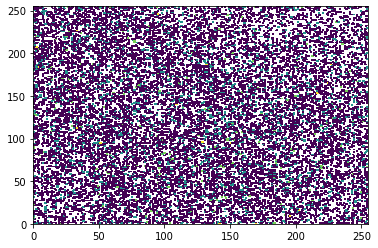

In [4]:
_ = plt.hist2d(df['x_mean'], df['y_mean'], bins=(256, 256), norm=LogNorm())
plt.show()

#### 2d plots for different circulatities

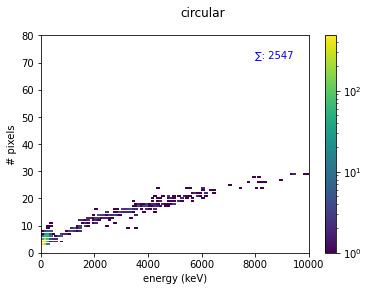

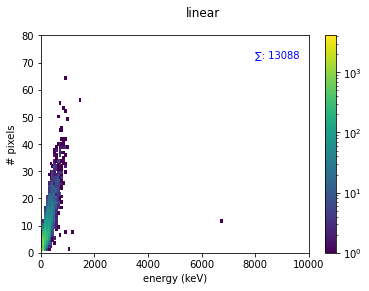

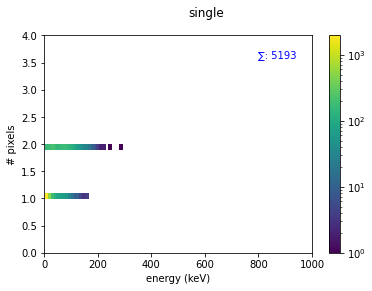

In [10]:
circularity_cut = 0.3
is_circular = df['circularity'] >= circularity_cut
is_linear = df['circularity'] < circularity_cut
is_single = df['n_pix'] <= 2
has_small_varmx = df['var_mx'] <= 0.5

is_alpha = is_circular & has_small_varmx

_ = plt.hist2d(df['energy'][is_alpha], df['n_pix'][is_alpha], bins = (100, 80), norm=LogNorm())
plt.xlim(0,10000)
plt.ylim(0,80)
plt.suptitle("circular & small variance")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_alpha.sum()}", transform=_ax.transAxes, color='b') 
plt.show()

_ = plt.hist2d(df['energy'][~is_alpha], df['n_pix'][~is_alpha], bins = (100, 80), norm=LogNorm())
plt.xlim(0,10000)
plt.ylim(0,80)
plt.suptitle("not (circular & small variance)")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_linear.sum()}", transform=_ax.transAxes, color='b') 
plt.show()

_ = plt.hist2d(df['energy'][is_single], df['n_pix'][is_single], bins = (100,10), norm=LogNorm()) 
plt.xlim(0,1000)
plt.ylim(0, 4)
plt.suptitle("single")
plt.colorbar()
plt.xlabel("energy (keV)")
plt.ylabel("# pixels")
_ax = plt.gca()
_ax.text(0.8, 0.9, f"∑: {is_single.sum()}", transform=_ax.transAxes, color='b') 
plt.show()


#### Discussion

These scatter plots show a very clear structure arising from the propeties of the detected particles.

  - alpha particles produce small, round clusters and deposit all of their energy in a small volume
  - beta particles produce long tracks in the material
  - photons procude - typically low-energy - electrons leading to signatures with
    very few or even isolated pixels

Note that some of the long tracks may have a significant "circularity" if they are bent !